In [2]:
from IPython.display import Markdown, display

display(Markdown("README.md"))

# Basics of Mobile Robotics - Project
Project for the EPFL course Basics of Mobile Robotics. 

2023, fall semester

# Group members
Badil Mujovi (274632)\
Aubin Mercier (316260)\
Mehmet Furkan Dogan (370234)\
Andrea Grillo (371099)
## Introduction
This project aims to combine vision, global and local navigation, and filtering to maneuver a Thymio robot in a predetermined environment.

Our environment consist of a white floor delimited by ArUco markers in the 4 corners. There is an ArUco marker on the Thymio and the goal is an ArUco marker too. Static obstacles are black polygones printed on the map. A camera is placed on top of the environment, to build a map of the static obstacles and compute the optimal path towards the goal.

The Thymio is placed at a random position, the camera tracks its position and orientation, and it has to reach the goal following the optimal path. The system is robust to 3D dynamic obstacles placed along the path, as well as camera covering for short periods of time and kidnapping, that is moving the robot to another place during its activity.

Our implementation includes the following features:
- Computer Vision for detecting obstacles and building the map
- Computer Vision for the tracking of the pose of the Thymio
- Global navigation computes the optimal path from the map using a visibility graph
- Local navigation makes the Thymio follow the computed path as a list of waypoints
- Obstacle avoidance by sensing the environment with proximity sensors
- Extended Kalman Filter allows pose estimation when the camera is covered using the fusion of data from camera and odometry
- Resilience to kidnapping by recomputing the global path when the camera detects that the position of the Thymio has changed
- ...


The main code of the system is implemented in this Jupyter noteboook. The submodules of the system have been implemented in Python classes, each one in a separate file. They are the following:
- Computer Vision - vision_thymio.py
- Global Navigation - global_navigation.py
- Extended Kalman Filter - extended_kalman_filter.py
- Local Navigation - local_navigation.py


Some scripts for testing the subsystems have been written, and they are located under the 'test' directory.
Moreover, for the estimation for the variance matrices for the Kalman Filter, measurements and subsequent data analysis in Matlab have been conducted. All the files related to this part can be found in the 'Sensor Noise Measurement' directory.


Below there is an explanation of each submodule, followed by the explanation of the main loop of the code.
## 1. Computer Vision
TODO

I have found this picture, don't know if it makes sense to use it
<div><img src = "images\detectAruco.png" width = 500 height = 500></div>

## 2. Path Planning
TODO
## 3. Filtering
### Extended Kalman Filter Model
We are using the following model for extended Kalman filter implementation:
$$
x_{i+1} = f(x_i,u_i) + w\\
z_{i+1} = h(x_i) + v
$$

where:

$$
x = 
\begin{bmatrix}
x\\
y\\
\theta\\
\bar{v}\\
\omega
\end{bmatrix}
$$

$$
u = 
\begin{bmatrix}
x_{\textrm{camera}}\\
y_{\textrm{camera}}\\
\theta_{\textrm{camera}}\\
\bar{v}_{\textrm{sensor}}\\
\omega_{\textrm{sensor}}
\end{bmatrix}
$$

State transition model:
$$
f(x_i,u_i) = 
\begin{bmatrix}
x_{i+1}\\
y_{i+1}\\
\theta_{i+1}\\
\bar{v}_{i+1}\\
\omega_{i+1}
\end{bmatrix} = 
\begin{bmatrix}
x_i + \bar{v}_i \cdot \Delta t \cdot \cos(\theta_i)\\
y_i + \bar{v}_i \cdot \Delta t \cdot \cos(\theta_i)\\
\theta_i + \omega_i \cdot \Delta t\\
\bar{v}_{\textrm{sensor}}\\
\omega_{\textrm{sensor}}
\end{bmatrix}
$$

State transition matrix can be found by calculating the Jacobian of the nonlinear state transition model.

$$
F = 
\begin{bmatrix}
1 & 0 & -\bar{v}\cdot \Delta t \cdot \sin(\theta_i) & 0 & 0\\
0 & 1 & -\bar{v}\cdot \Delta t \cdot \cos(\theta_i) & 0 & 0\\
0 & 0 & 1 & 0 & 0\\
0 & 0 & 0 & 1 & 0\\
0 & 0 & 0 & 0 & 1
\end{bmatrix}
$$

State transition can be implemented as:
```py
    def _state_transition(self, x, u, dt):
        # State transition function for a differential drive robot
        v_bar,omega = u

        x_new = x[0] + v_bar * dt * np.cos(x[2])
        y_new = x[1] + v_bar * dt * np.sin(x[2])
        theta_new = x[2] + omega * dt

        return np.array([x_new, y_new, theta_new, v_bar, omega])

    def _calculate_state_transition_matrix(self, x, u, dt):
        # Jacobian matrix A of the state transition function

        v_bar,omega = u
        #v_right, v_left = u
        #v_bar = (v_right + v_left) / 2.0
        theta_i = x[2]

        A = np.array([
            [1, 0, -v_bar * dt * np.sin(theta_i), 0, 0],
            [0, 1, v_bar * dt * np.cos(theta_i), 0, 0],
            [0, 0, 1, 0, 0],
            [0, 0, 0, 1, 0],
            [0, 0, 0, 0, 1]
        ])

        return A
```

Measurement model:
$$
h(x_i) = 
\begin{bmatrix}
x_{\textrm{camera}}\\
y_{\textrm{camera}}\\
\theta_{\textrm{camera}}\\
\bar{v}_{\textrm{sensor}}\\
\omega_{\textrm{sensor}}
\end{bmatrix}
$$

Measurement jacobian:
$$
H = 
\begin{bmatrix}
1 & 0 & 0 & 0 & 0\\
0 & 1 & 0 & 0 & 0\\
0 & 0 & 1 & 0 & 0\\
0 & 0 & 0 & 1 & 0\\
0 & 0 & 0 & 0 & 1
\end{bmatrix}
$$

Measurement model can be implemented as:
```py
    def _measurement_model(self, x):
        # x, y, and theta are measured usıng the camera
        # v_right and v_left are measured using velocity sensors
        return x

    def _calculate_measurement_jacobian(self, x):
        # Calculate the Jacobian matrix H of the measurement model
        H = np.eye(5)

        return H
```

### Prediction Step
$$
x_{i+1} = f(x_i,u_i)
$$
$$
P = F \cdot P \cdot F^T + Q
$$
where $P$ is the error covariance matrix and Q is the process noise covariance matrix. We can implement that in pyhon as:

```py
    def predict(self, control_input, dt):
        # Update the state transition matrix A based on the control input
        A = self._calculate_state_transition_matrix(self.state, control_input, dt)

        # Predict the state and error covariance
        self.state = self._state_transition(self.state, control_input, dt)
        self.P = A @ self.P @ A.T + self.process_noise_cov

        self._angle_modulus()
```

### Update Step
Innovation covariance matrix can be calculated as:
$$
S = H \cdot P \cdot H^T + R
$$
Optimal Kalman gain can be calculated as:
$$
K = P \cdot H^T \cdot S^{-1}
$$
Updated state estimate:
$$
x_{i+1} = x_i + K \cdot (z_i - H_i \cdot x_i)
$$
Updated error covariance:
$$
P = (I - K\cdot H)\cdot P
$$

We can implement that in pyhon as:
```py
    def update(self, measurement):
        # Calculate the measurement Jacobian matrix H
        H = self._calculate_measurement_jacobian(self.state)

        # Calculate the innovation covariance S
        S = H @ self.P @ H.T + self.measurement_noise_cov

        # Calculate the Kalman gain
        K = self.P @ H.T @ np.linalg.inv(S)

        # Update the state and error covariance
        innovation = measurement - self._measurement_model(self.state)
        self.state = self.state + K @ innovation
        self.P = (np.eye(self.state_dim) - K @ H) @ self.P

        self._angle_modulus()
```

### Tuning Covariance Matrices

To tune the measurement covariance matrix, we used the measured speed values when motor is commanded to run at a fixed speeds. You can see the distributions of the wheel speed measurements for different speeds.

<center><div><img src = "images\wheel_speed_distribution.png" width = 350></div></center>

To find the wheel speed sensor noise covariance matrix, the following error distribution is used.

<center><div><img src = "images\measurement_error_distribution.png" width = 350></div></center>

We have found the camera noise covariance matrix in a similar way. Lastly, process noise covariance matrix is tuned by trial and error to get an optimal behaviour.

## 4. Local Navigation
The goal of the Local Navigation submodule is to make the Thymio follow the path computed by the Global Navigation part, while making the Thymio avoid dynamic obstacles that can be placed along the path.

The path is given as a list of tuples (x,y) representing the waypoints of the path. The path is initialized using the `define_path` function. In this function, also the `waypoint_counter` variable is initialized. This variable keeps track of which waypoint we are aiming for at the moment.

#### Control routine
The function which is called at every loop iteration is `control`, whose role is to decide whether to apply the controller to follow the path or the local avoidance routine.
The system starts in the <i>path_follow</i> modality, which is changed to <i>obstacle_avoidance</i> whenever the proximity sensor detect an obstacle. When no obstacle is detected anymore, the obstacle avoidance routine will be run for the following 5 loop cycles before going back to the <i>path_follow</i> mode, to ensure that the obstacle is really been overcome and that the Thymio is far enough from it.


#### Obstacle avoidance routine
The obstacle avoidance routine, as implemented in the `obst_avoid` function, is a simple application of a Neural Network as seen during the course.
<center><div><img src = "images\NNobstacleAvoidance.png" width = 350></div></center>

The input of the network are the readings of the sensors, which are then multiplied by the weights and summed together to get the velocity of the motors.
The two rear sensors of the Thymio have been assigned zero weight, as the Thymio will always move forward so it cannot detect any obstacle from the rear.
To make the Thymio go forward during the obstacle avoidance phase, a constant velocity is added to both neurons as an additional fixed input.

The main difference with the code used during the exercise session, is that in that case the routine has been run on the Thymio using the Aseba transpiler. To integrate the obstacle avoidance in the whole project, the routine is run in Python on the computer. For this reason, the communication latency has to be taken into account, and this leads to the necessity to tune the sampling time in an effective way, as will be explained after.

The weights of the two neurons have been tuned empirically by trial and error. One interesting detail to note is that for the central sensor two different weigths have been chosen for the left and right wheel. This is because otherwise the Thymio could get blocked in case of an obstacle exactly in front of the robot and perpendicular to the longitudinal line of the Thymio. By setting asymmetrical weights, the Thymio will rotate and not get blocked in this situation.



#### Path follow routine
The function `path_follow` has the pose of the Thymio as the only parameter, as the path is defined as an attribute of the Local Navigation class.
The idea is that the two variables to control are the linear and angular velocities, respectively $ v $ and $ \omega $.

The controller chosen is a simple proportional controller for the $ \omega $, and a predefined fixed velocity for $ v $. 

The control law is therefore:
$$ v = v_{fixed} $$
$$ \omega = K_p ( \theta - \gamma) $$
where $ \theta $ is the orientation of the Thymio and $ \gamma $ is the angle of the vector connecting the Thymio to the waypoint. 

### TODO INSERT IMAGE of the angles

The routine checks if the waypoint has been reached, by checking that the actual pose is within a distance $ \epsilon $ of the waypoint. If the condition is true, the `waypoint_counter` variable is incremented and the function is called recursively, until the last goal is reached.

The gain value $ K_p $, the fixed velocity $ v_{fixed} $, and the $ \epsilon $ parameter have been tuned empiricaly by trial and error to obtain the best performance possible of the system as a whole.

### Simulating the controller
To make sure that the controller works before testing it with the Thymio, a simulation has been done as a proof of concept.
The simulation can be done defining a random path and start point, and using the formulas below to integrate the position of the Thymio at every step:
$$ x_{i+1} = x_i + v \cdot cos(\theta) \cdot \Delta t $$
$$ y_{i+1} = y_i + v \cdot sin(\theta) \cdot \Delta t $$
$$ \theta_{i+1} + \theta_i + \omega \cdot \Delta t $$
The result of the simulation can be seen in the graph below:
<center><div><img src = "images\controller.png" width = 500></div></center>

The code used to do the simulation can be found inside the `test` directory, in the `local_navigation_test.py` file.




## Complete code

TODO


choice of DT

## Conclusion

# SCAFFOLDING

### Installing dependencies

In [1]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install pyvisgraph
!{sys.executable} -m pip install opencv-python
!{sys.executable} -m pip install opencv-contrib-python
!{sys.executable} -m pip install tqdm

^C


### Constant Definition, libraries and submodules import

In [3]:
#  - - - CONSTANT DEFINITION - - -

USE_THYMIO = True

# sampling time
DT = .2

# 
EPSILON_KIDNAP = 30

HEIGHT_ROI = 72
WIDTH_ROI  = 107.4 

print("Constants defined")

#  - - - IMPORTS - - - 
import tdmclient.notebook
import time
import numpy as np
import cv2
from matplotlib import pyplot as plt

import local_navigation
import extended_kalman_filter
import vision_thymio
import global_navigation as gn

print("Import executed successfully")

if USE_THYMIO:
    await tdmclient.notebook.start()
    print("Successfully connected to Thymio.")

Constants defined
Import executed successfully
Successfully connected to Thymio.


### Classes instantiation, helper functions to interact with the Thymio

In [4]:
# ISTANTIATE OBJECTS OF CLASSES

vis = vision_thymio.Vision_Thymio()
local_nav = local_navigation.Local_Navigation()
ekf = extended_kalman_filter.ExtendedKalmanFilter()

print("Classes defined correctly.")


# FUNCTION FOR THYMIO INTERACTION DEFINITION

@tdmclient.notebook.sync_var
def motor_go(left,right):
    global motor_left_target, motor_right_target
    motor_left_target = left
    motor_right_target = right
    
@tdmclient.notebook.sync_var
def motor_stop():
    global motor_left_target,motor_right_target
    motor_left_target = 0
    motor_right_target = 0
    
@tdmclient.notebook.sync_var
def sensor_data():
    global prox_horizontal
    return prox_horizontal.copy()

@tdmclient.notebook.sync_var
def odometry():
    global motor_left_speed, motor_right_speed
    return (motor_left_speed, motor_right_speed)

print("Thymio functions defined correctly.")

Init Vision Thymio
Init Local Navigation
Init Extended Kalman Filter
Classes defined correctly.
Thymio functions defined correctly.


In [5]:
# TEST THAT THE THYMIO IS LISTENING TO US
motor_go(200,200)
time.sleep(1)
motor_stop()

### Perspective and scaling of the image, static obstacle detection

In [6]:
# init of the perspective and scaling of the image
vis.getPerspectiveAndScaling(width_roi=WIDTH_ROI, height_roi=HEIGHT_ROI)

# get obstacles on the map
img = vis.getCorrectedImage()
staticObstacleList, frame = vis.getVisibilityGraph(img)

staticObstacleList = staticObstacleList.copy()

print(staticObstacleList)


[array([[594, -48],
       [277, -34],
       [319, 681],
       [631, 659]], dtype=int32)]


### Detection of the Thymio and the goal, optimal path computation

Found thymio and goal at iteration 0
Position of the thymio:  [100.71  36.63] 2.6934476785140036
Position of the goal:  [11.61 41.76]
test
Computed optimal path:  [(100.71, 36.54), (56.79, 59.309999999999995), (28.709999999999997, 61.29), (11.61, 41.76)]


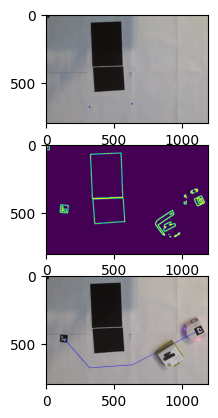

Unchecked Raise(exc=Call(func=Name(id='Exception', ctx=Load()), args=[Constant(value='ERROR - cannot find thymio or goal thymio: '), Name(id='foundThymio', ctx=Load()), Constant(value=', goal: '), Name(id='foundGoal', ctx=Load())], keywords=[]))


In [13]:
def detectAndComputePath():
    global path,staticObstacleList,ekf,local_nav,path_img, oldThymioPos

    try:
        foundGoal = foundThymio = False
        goalPos = []
        thymioPos = []

        # try ten times to get thymio and goal position on the map, if not print error and exit
        for i in range(10):
            img = vis.getCorrectedImage()
            img = vis.getCorrectedImage()
            ids,corners = vis.detectArucoMarkers(img)

            if not foundGoal:
                foundGoal, goalPos = vis.getGoalPosition(ids, corners)
            if not foundThymio:
                foundThymio, thymioPos = vis.getThymioPos(ids,corners) 

            if foundGoal and foundThymio:
                break
            
            time.sleep(0.1)
        if not (foundGoal and foundThymio):
            raise Exception("ERROR - cannot find thymio or goal thymio: ", foundThymio, ", goal: ", foundGoal)

        print(f"Found thymio and goal at iteration {i}")
        print(f"Position of the thymio: ", thymioPos[0], thymioPos[1])
        print(f"Position of the goal: ", goalPos)

        test = gn.prepareImage(img)
        path, path_img = vis.getOptimalPath(thymioPos[0], staticObstacleList.copy(), goalPos, img)

        # path reshaping to be used by the local navigation module
        path = list(map(tuple, path.reshape((path.shape[0], 2))))
        
        print("Computed optimal path: ", path)

        local_nav.define_path(path)

        oldThymioPos = local_nav.path[0]

        #EKF state initialization
        initial_state = np.array([thymioPos[0][0],thymioPos[0][1], thymioPos[1], 0, 0])  # [x, y, theta, v, w]
        ekf.state_initialization(initial_state)


        #display the image

        f, axarr = plt.subplots(3,1)

        axarr[0].imshow(frame)
        axarr[1].imshow(test)
        axarr[2].imshow(path_img)

    except Exception as e:
        print(e)

detectAndComputePath()
motor_stop()


In [18]:
import importlib
importlib.reload(local_navigation)
local_nav = local_navigation.Local_Navigation()

Init Local Navigation


0.15
Found thymio and goal at iteration 0
Position of the thymio:  [101.88  36.72] 2.723368324010564
Position of the goal:  [ 8.82 44.1 ]
test
Computed optimal path:  [(101.88, 36.72), (56.79, 59.309999999999995), (28.709999999999997, 61.29), (8.82, 44.1)]
reached objective number 0
reached objective number 1
reached objective number 2
reached objective number 3
finished!
finished at iteration n  170


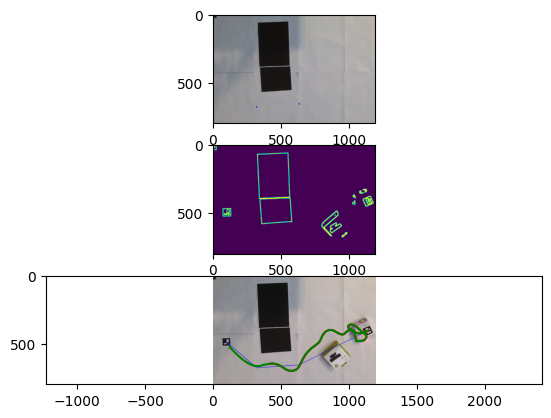

In [20]:
finished = False
DT = .15
print(DT)
detectAndComputePath()
trajectory_x = []
trajectory_y = []

trajectory_kalman_x = []
trajectory_kalman_y = []
i = 0

v,w = 0,0

while not finished:
    i += 1
    # Getting the position from the camera
    img = vis.getCorrectedImage()
    ids,corners = vis.detectArucoMarkers(img)
    foundThymio, thymioPos = vis.getThymioPos(ids,corners) 
 

    if foundThymio:
        ekf.set_mode(extended_kalman_filter.NORMAL)
        
        x_meas, y_meas, theta_meas = thymioPos[0][0], thymioPos[0][1], thymioPos[1] # Position and orientation from the camera
        trajectory_x.append(x_meas)
        trajectory_y.append(y_meas)
        measurement = np.array([x_meas, y_meas, theta_meas, v, w])\
        
        if local_nav.dist(oldThymioPos,thymioPos[0]) > EPSILON_KIDNAP:
            print(" - - - KIDNAPPING DETECTED - RECOMPUTING OPTIMAL PATH - - - ")
            detectAndComputePath()
            continue
        oldThymioPos = thymioPos[0]
            



    else:
        # print("- - - CAMERA COVERED - - -")
        ekf.set_mode(extended_kalman_filter.KIDNAPPED)
    

    


 
    x, y, theta, v, w = ekf.state
    # print("Camera state:", x_meas,y_meas,theta_meas)
    # print("Kalman state:", x,y,theta)

    (v,w), (wl,wr),finished = local_nav.control((x,y,theta), sensor_data())

    # linear and angular velocity unit conversions
    v = v*19.5/5000
    w = (wl-wr)*8.75/(4.7*500)

    # print('v = ',v,' cm/s\tw = ',w,'rad/s')
    # print('wl = ',wl,'\twr = ',wr)

    control_input = np.array([v,w])
    measurement[3] = v
    measurement[4] = w


    # Perform prediction and update steps
    ekf.predict(control_input, DT)
    ekf.update(measurement)

    x, y, theta, v, w = ekf.state
    trajectory_kalman_x.append(x)
    trajectory_kalman_y.append(y)
    sensors = sensor_data()

    motor_go(int(wl),int(wr))

    if abs(wl) > 4000 or abs(wr) > 4000:
        print(f"SATURATED")

    time.sleep(DT)
motor_stop()
print("finished at iteration n ", i)

plt.imshow(path_img)
plt.plot(np.array(trajectory_x)/vis.scalingFactor, np.array(trajectory_y)/vis.scalingFactor, color='red')
plt.plot(np.array(trajectory_kalman_x)/vis.scalingFactor, np.array(trajectory_kalman_y)/vis.scalingFactor, color='green')
plt.axis('equal')
plt.show()   


In [6]:
motor_stop()